# Additional visualizations

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import scanpy as sc
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import os

from skin_ilc_util import cm_purple_scatter, subplots_fixed_width, \
    power_cmap, mpl_set_default_style, day_palette, annotate, \
    CenterNormalize, cm_topic

In [4]:
mpl_set_default_style(matplotlib.rcParams)
pointsize = 10

## Load data

In [5]:
data_dir = os.path.join('.', 'data')
adata_variable_fname = os.path.join(data_dir, 'sct_variable.h5ad')
adata_full_fname = os.path.join(data_dir, 'sct.h5ad')

In [6]:
adata = sc.read(adata_variable_fname)
adata_full = sc.read(adata_full_fname)
adata_restr = adata_full[adata_full.obs['lda_17'] < 0.08]

## Cells by day

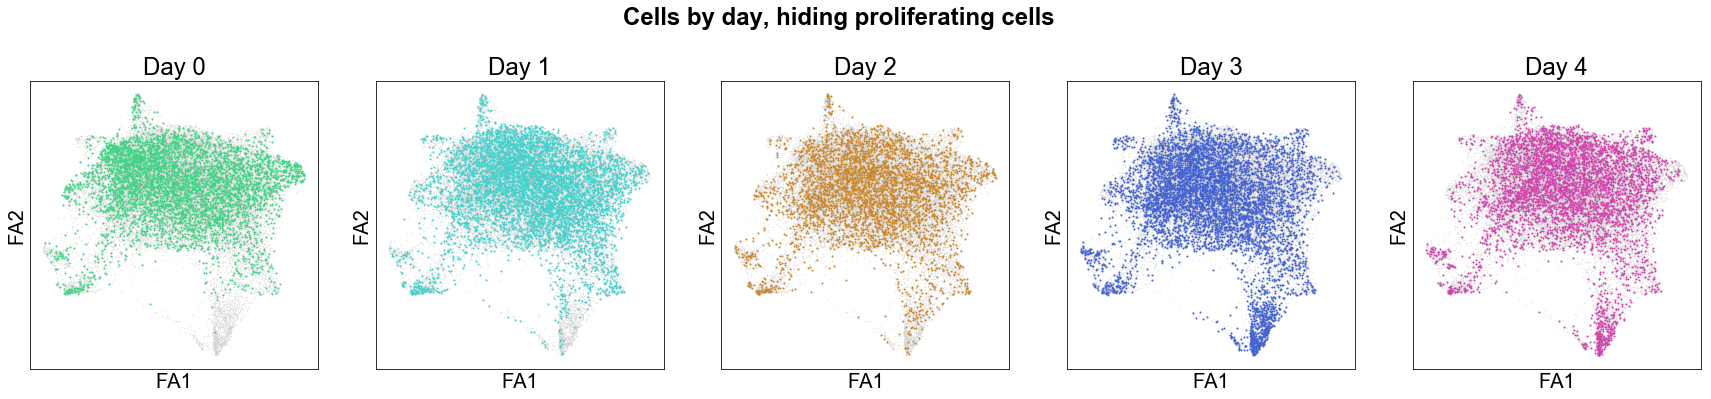

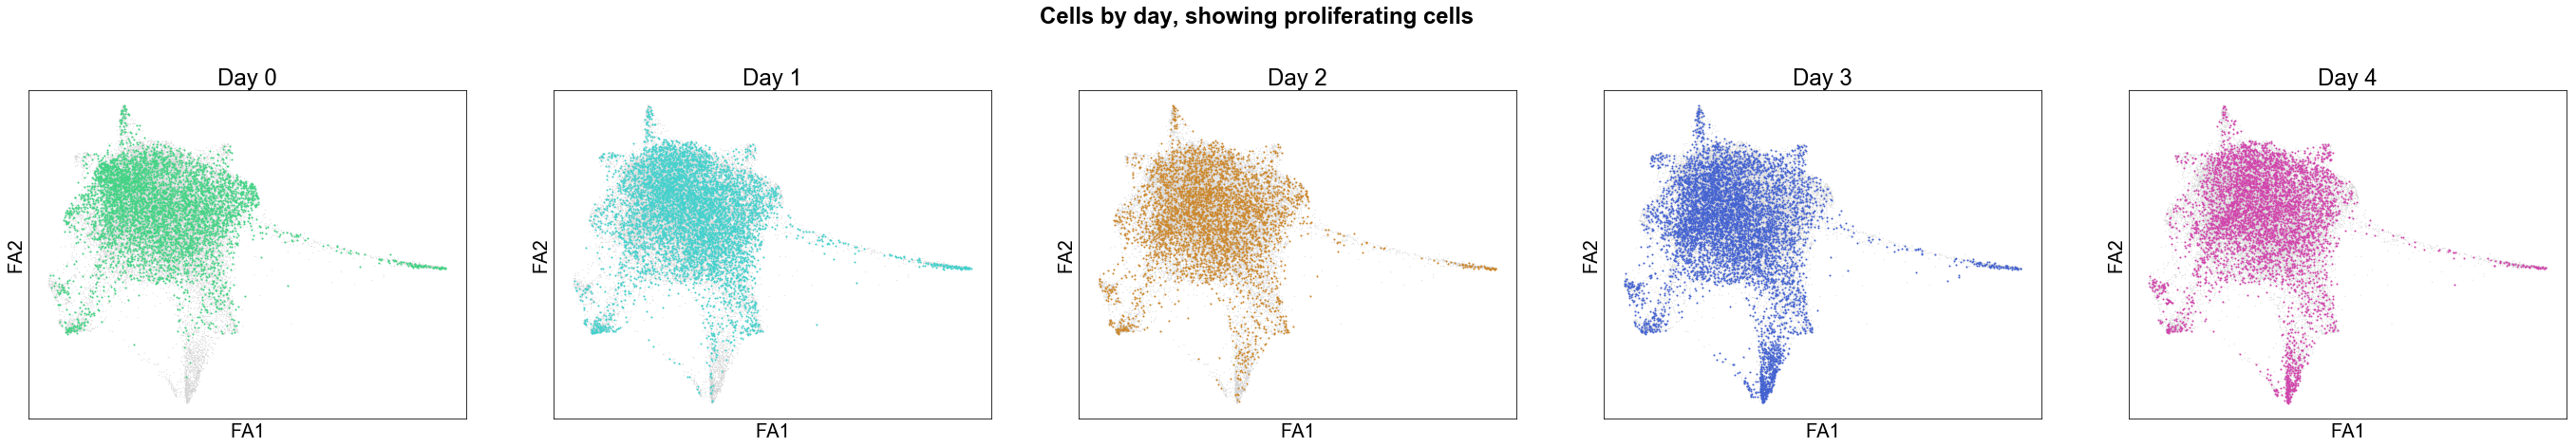

In [7]:
for show_prolif in [False, True]:
    # Adjust figure size
    if show_prolif:
        figsize = (6.4, 4.8)
        adata_plot = adata_full
    else:
        figsize = (4, 4)
        adata_plot = adata_restr
        
    fig, axes = subplots_fixed_width(1, len(adata_plot.obs['day'].unique()), figsize = figsize, top = 0.8)
    for day, ax in zip(adata_plot.obs['day'].unique(), axes.flatten()):
        sc.pl.draw_graph(adata_plot, cmap = 'grey', ax = ax, show = False)
        ax.scatter(*adata_plot[adata_plot.obs['day'] == day].obsm['X_draw_graph_fa'].T, c = [day_palette[int(day)]],
                  s = pointsize*0.1)
        ax.set_title(f'Day {day}')
        title_str = f'Cells by day, '
        title_str += 'showing proliferating cells' if show_prolif else 'hiding proliferating cells'
        fig.suptitle(title_str, weight = 'bold')

## Visualize specific genes

In [8]:
pointsize = 10

### Fig 2 genes

In [9]:
fig2_genes = ['Gata3', 'Klf2', 'Il13', 'Calca', 'Il22']
cm_adjustments = {
    'Gata3' : 2.0,
    'Il13' : 2.0,
    'Bcl11b' : 2.0,
    'Klf4' : 1.5,
    'Lgals3' : 2.0,
    'S100a11' : 2.5,
    'Lgals1' : 3.0,
    'Vim' : 3.0,
    'Kdm6b' : 2.0
}

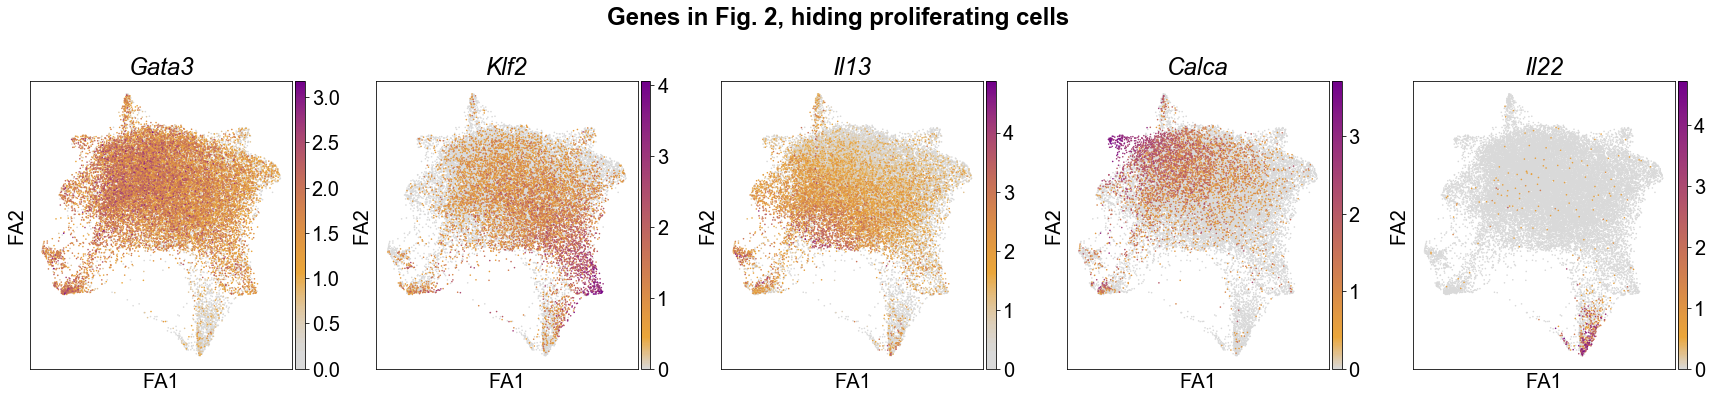

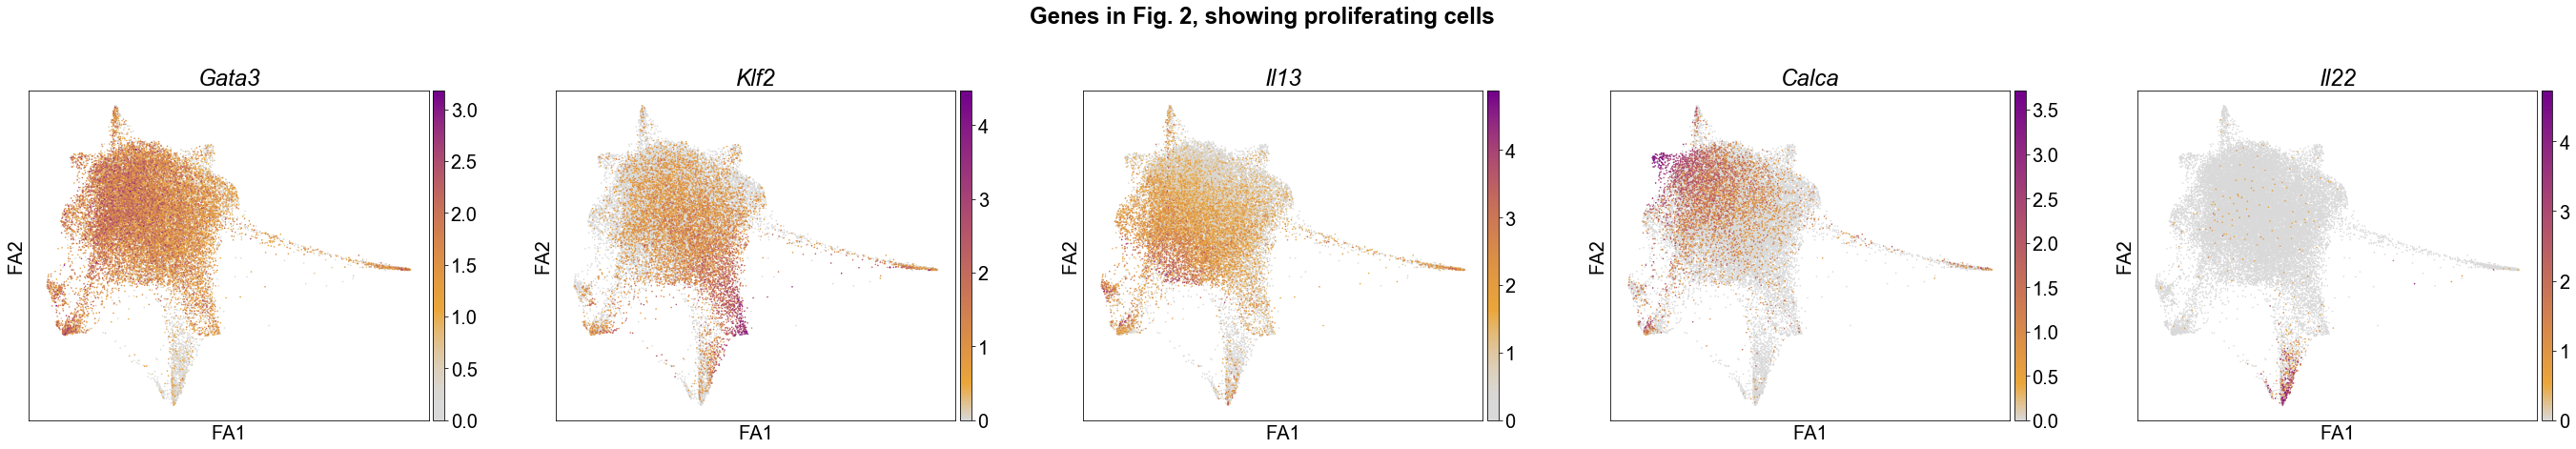

In [10]:
for show_prolif in [False, True]:
    # Adjust figure size
    if show_prolif:
        figsize = (6.4, 4.8)
        adata_plot = adata_full
    else:
        figsize = (4, 4)
        adata_plot = adata_restr
        
    fig, axes = subplots_fixed_width(1, len(fig2_genes), figsize = figsize, top = 0.8)
    for gene, ax in zip(fig2_genes, axes.flatten()):
        power = cm_adjustments.get(gene, 1.0)
        sc.pl.draw_graph(adata_plot, color = gene,
                         cmap = power_cmap(cm_purple_scatter, power), s = pointsize, ax = ax, show = False)
        ax.title.set_fontstyle('italic')
        title_str = f'Genes in Fig. 2, '
        title_str += 'showing proliferating cells' if show_prolif else 'hiding proliferating cells'
        fig.suptitle(title_str, weight = 'bold')

### Bcl11b

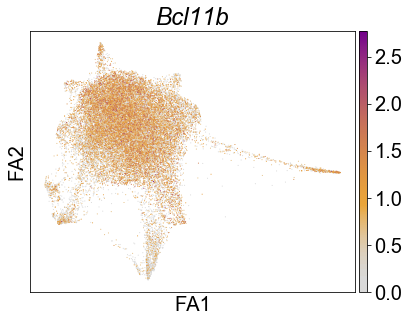

In [11]:
power = cm_adjustments.get('Bcl11b', 1.0)
fig, ax = plt.subplots(figsize = (6.4, 4.8))
sc.pl.draw_graph(adata_full, color = 'Bcl11b', cmap = power_cmap(cm_purple_scatter, power), ax = ax, show = False)
ax.title.set_fontstyle('italic')

### Extended Data Fig 4 genes

In [12]:
edfig4_genes = ['Klf4', 'Jun', 'Csf2', 'Lgals3', 'Rorc', 'Il4']

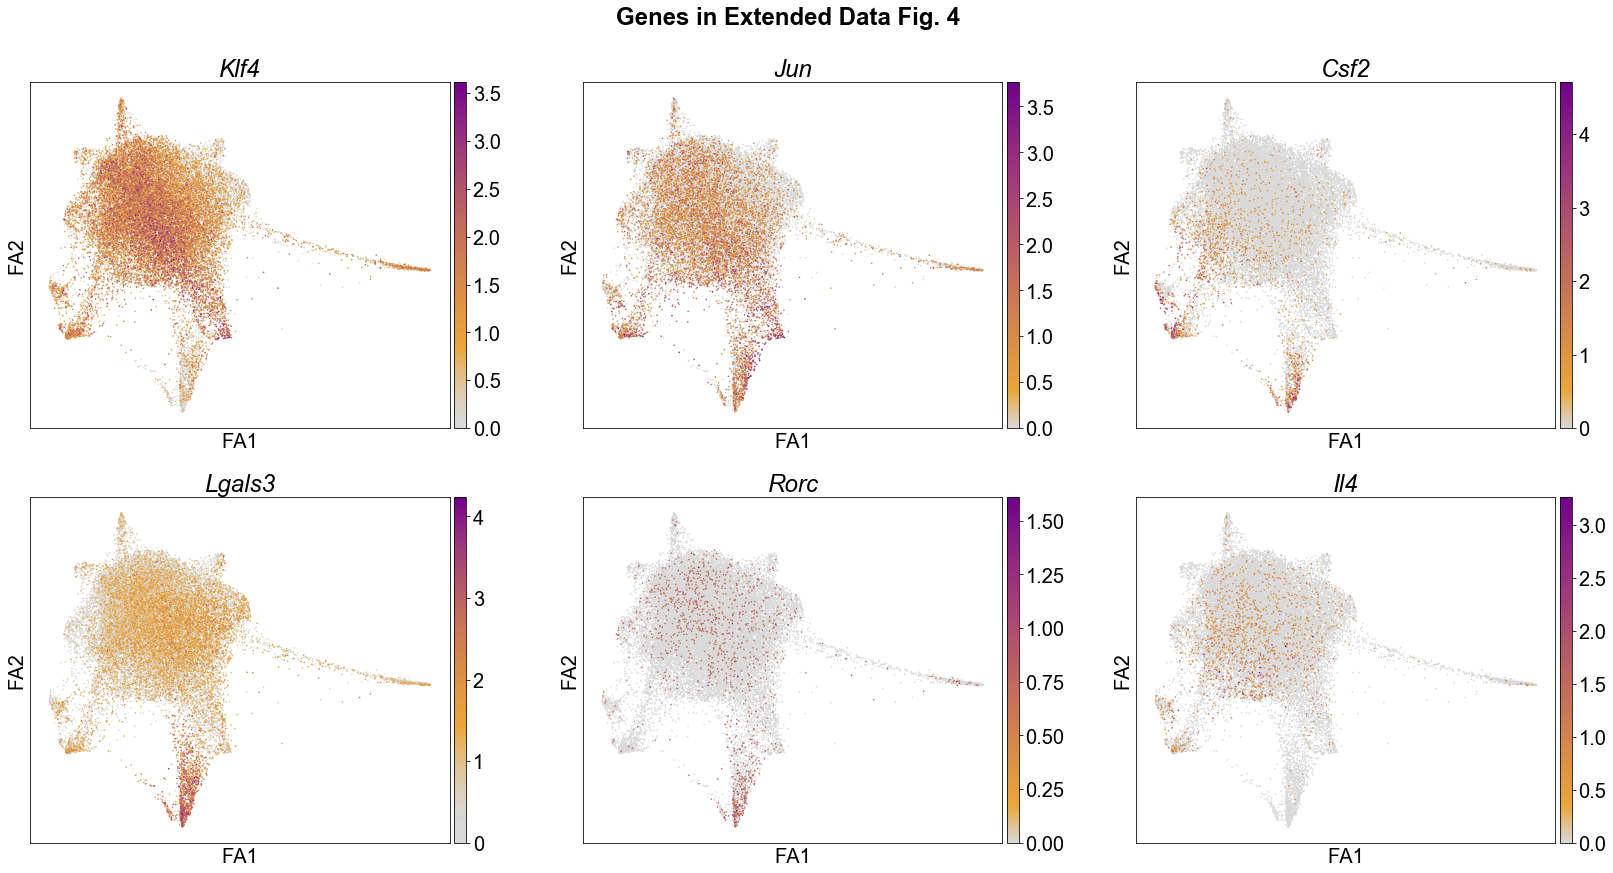

In [13]:
adata_plot = adata_full
        
fig, axes = subplots_fixed_width(2, 3, figsize = figsize, top = 0.9)
for gene, ax in zip(edfig4_genes, axes.flatten()):
    power = cm_adjustments.get(gene, 1.0)
    sc.pl.draw_graph(adata_plot, color = gene,
                     cmap = power_cmap(cm_purple_scatter, power), s = pointsize, ax = ax, show = False)
    ax.title.set_fontstyle('italic')
    title_str = f'Genes in Extended Data Fig. 4'
    fig.suptitle(title_str, weight = 'bold')

### Extended Data Fig 5 genes, CGRP

In [14]:
edfig5_genes = ['Adm', 'Calca', 'Ramp1', 'Ramp3', 'Calcrl']

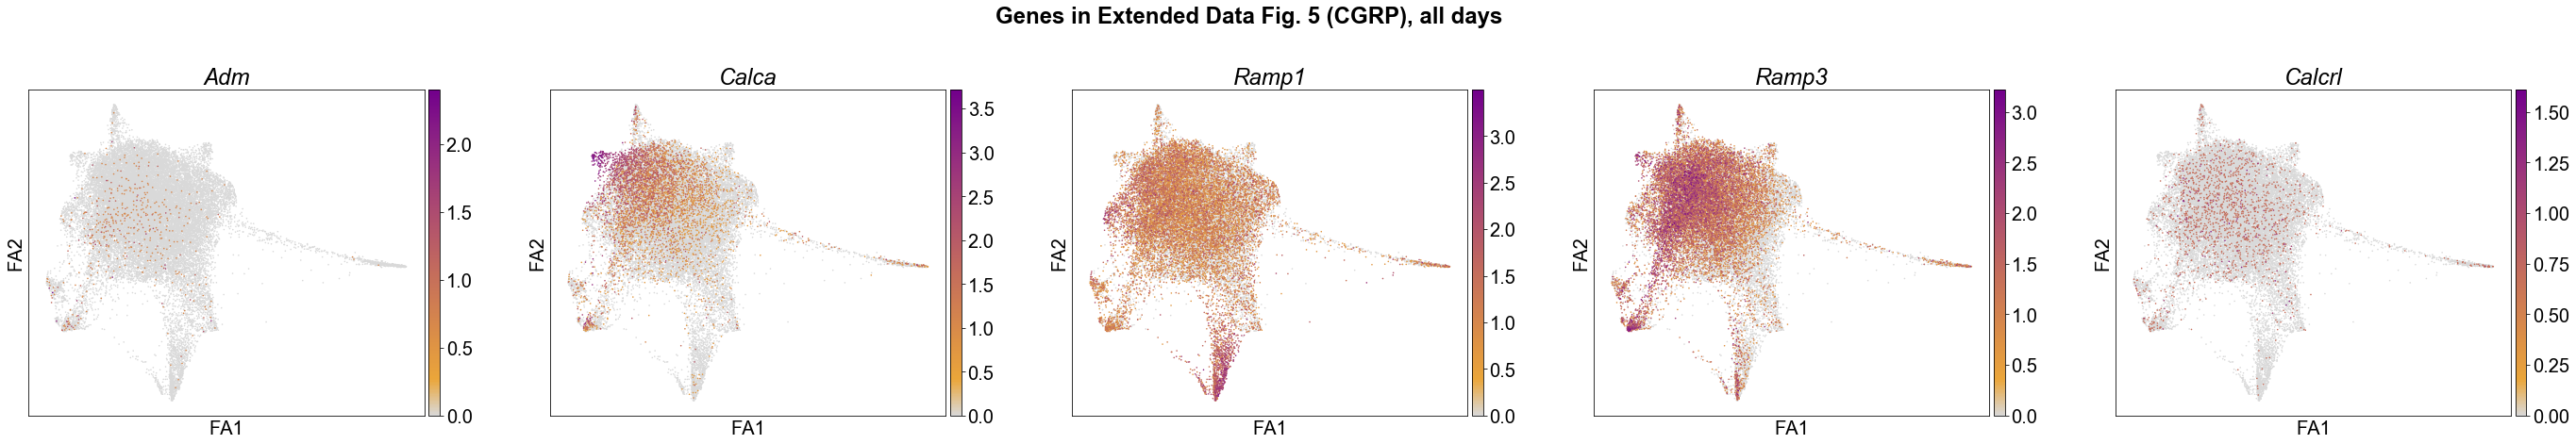

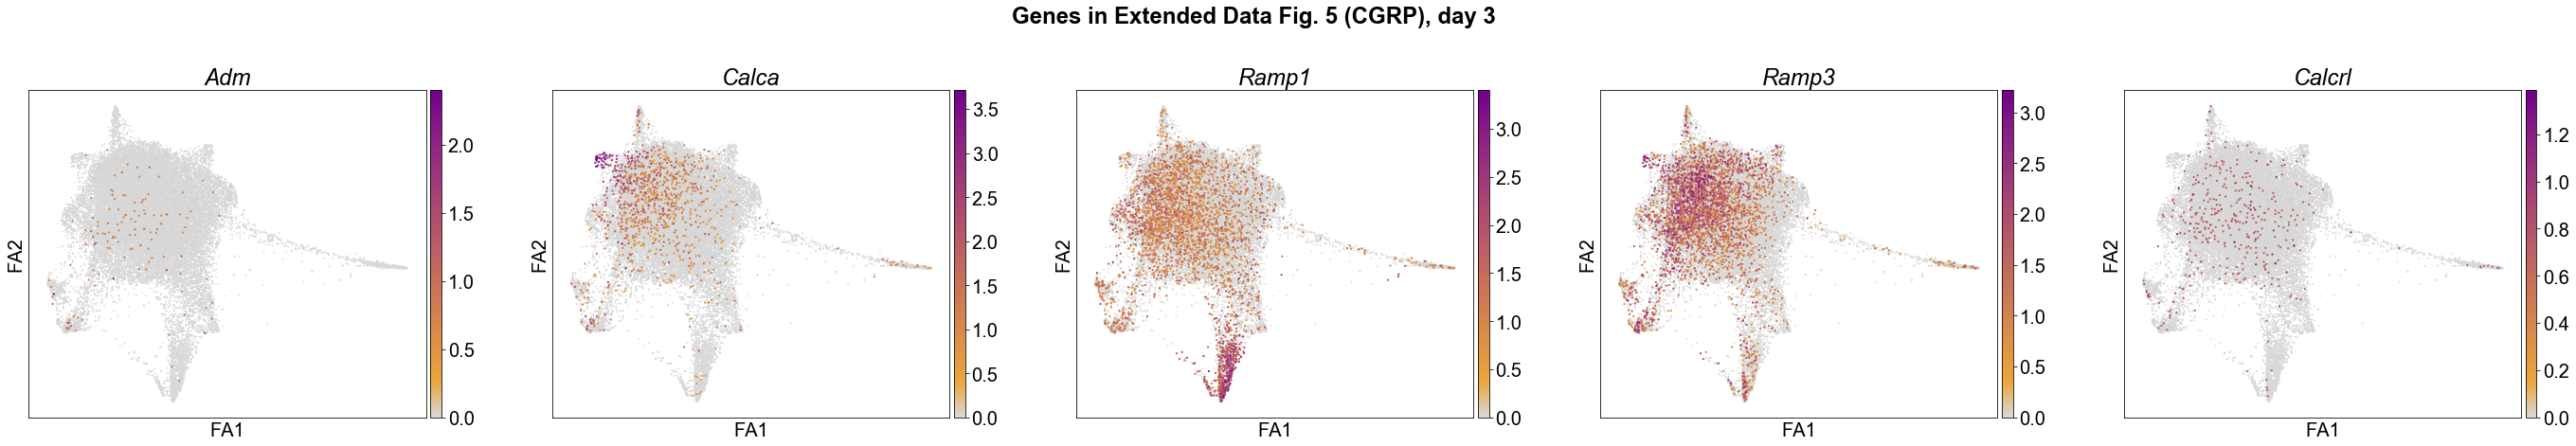

In [15]:
adata_day3 = adata_full[adata_full.obs['day'] == '3']
figsize = (6.4, 4.8)

for restricted in [False, True]:
    if restricted:
        adata_plot = adata_day3
    else:
        adata_plot = adata_full

    fig, axes = subplots_fixed_width(1, 5, figsize = figsize, top = 0.8)
    for gene, ax in zip(edfig5_genes, axes.flatten()):
        power = cm_adjustments.get(gene, 1.0)
        if restricted:
            sc.pl.draw_graph(adata_full, ax = ax, s = pointsize, show = False)
        plot_pointsize = 20 if restricted else 10
        sc.pl.draw_graph(adata_plot, color = gene,
                         cmap = power_cmap(cm_purple_scatter, power), s = plot_pointsize, ax = ax, show = False)
        ax.title.set_fontstyle('italic')
        title_str = f'Genes in Extended Data Fig. 5 (CGRP), '
        title_str += 'all days' if not restricted else 'day 3'
        fig.suptitle(title_str, weight = 'bold')

#### Box plots

Prepare data frames

In [16]:
def calc_cutoffs(df, col_var, sel_var, bar_select = 6):
    # Precalculate quantiles
    cutoffs = {}
    for col in df[col_var].unique():
        cutoffs[col] = float(df.query(f'{col_var} == "{col}"').groupby(sel_var).\
                              agg(lambda x: np.percentile(x, 100*(1 - 2**(-bar_select)))).max())
    return cutoffs

In [17]:
df = pd.DataFrame(adata_full[:, edfig5_genes].X.toarray())
df.index = adata.obs.index
df.columns = edfig5_genes
df = df.join(adata.obs[['day', 'lda_2', 'lda_3', 'lda_5']])

df2 = df[df['lda_2'] > 0.3].copy()
df2['selection'] = 'ILC2'
df3 = df[df['lda_3'] > 0.2].copy()
df3['selection'] = 'ILC3'
df4 = df[df['lda_5'] > 0.175].copy()
df4['selection'] = 'Topic 5'

#df_combined = pd.concat([df1, df2, df3, df4]).drop(columns = ['lda_2', 'lda_3', 'lda_5'])
df_combined = pd.concat([df2, df3, df4]).drop(columns = ['lda_2', 'lda_3', 'lda_5'])
df_combined = df_combined[df_combined['day'] == '3'].drop(columns = 'day').reset_index(drop = True)
dfm = df_combined.melt(id_vars = ['selection'], var_name = 'Gene', value_name = 'Expression')

cutoffs = calc_cutoffs(dfm, col_var = 'Gene', sel_var = 'selection')

Calculate p-values.

In [18]:
# Pvalues
gene_col = []
set1_col = []
set2_col = []
pval_col = []
sets = list(dfm['selection'].unique())

for gene in edfig5_genes:
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            gene_col.append(gene)
            set1_col.append(sets[i])
            set2_col.append(sets[j])
            pval_col.append(
                scipy.stats.mannwhitneyu(dfm.query(f'Gene == "{gene}" & selection == "{sets[i]}"')['Expression'],
                                         dfm.query(f'Gene == "{gene}" & selection == "{sets[j]}"')['Expression'],
                                         alternative = 'two-sided')[1])
pval_df = pd.DataFrame({'Gene' : gene_col, 'set1' : set1_col, 'set2' : set2_col, 'pval' : pval_col})
pval_df['pval'] *= len(pval_df)
pval_df['reject'] = pval_df['pval'] <= 0.01
pval_df['h_fact'] = 0.03
pval_df['y_fact'] = 0.02
pval_df['text_fact'] = 0.03
pval_df['x_shrink'] = 0.00

Set parameters for annotations

In [19]:
spread_fact = 0.165
x_shrink = 0.03

pval_df.loc[(pval_df['Gene'] == 'Adm') & (pval_df['set1'] == 'all') & (pval_df['set2'] == 'ILC3'), 'x_shrink'] = x_shrink
pval_df.loc[(pval_df['Gene'] == 'Adm') & (pval_df['set1'] == 'ILC3') & (pval_df['set2'] == 'Topic 5'), 'x_shrink'] = x_shrink
pval_df.loc[(pval_df['Gene'] == 'Adm') & (pval_df['set1'] == 'all') & (pval_df['set2'] == 'Topic 5'), 'y_fact'] += 2 * spread_fact
pval_df.loc[(pval_df['Gene'] == 'Adm') & (pval_df['set1'] == 'ILC2') & (pval_df['set2'] == 'Topic 5'), 'y_fact'] += spread_fact

pval_df.loc[(pval_df['Gene'] == 'Calcrl') & (pval_df['set1'] == 'ILC2') & (pval_df['set2'] == 'Topic 5'), 'y_fact'] += spread_fact
pval_df.loc[(pval_df['Gene'] == 'Calcrl') & (pval_df['set1'] == 'all') & (pval_df['set2'] == 'Topic 5'), 'y_fact'] += 2 * spread_fact

Plot.

`*` here means 0.01 cutoff

Text(0.5, 1.8, 'Day 3')

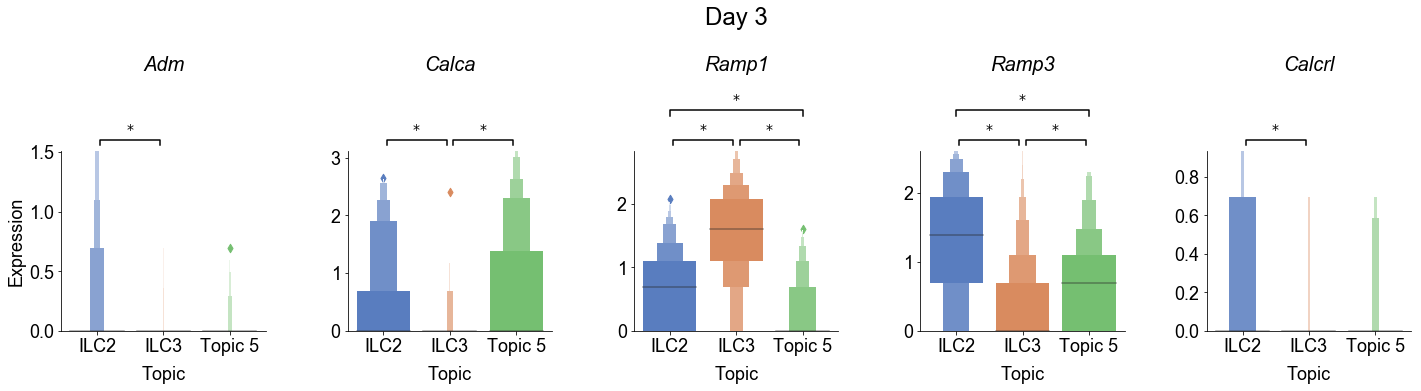

In [20]:
g = sns.catplot(x = 'selection', y = 'Expression', col = 'Gene', data = dfm, col_wrap = 5,
                kind = 'boxen', sharey = False,
                palette = 'muted', aspect = 1.5, height = 2.5,
                #bw = 0.4
               )
g.set_titles('{col_name}', pad = 80)
g.set_xlabels('Topic')
for ax, gene in zip(g.axes, edfig5_genes):
    small_df = dfm[dfm['Gene'] == gene]
    ax.set_ylim([0, cutoffs[gene]])
    ax.title.set_fontsize(20)
    ax.title.set_fontstyle('italic')
    ax.xaxis.get_label().set_fontsize(18)
    ax.yaxis.get_label().set_fontsize(18)
    ax.tick_params(labelsize = 18)
    ax.xaxis.labelpad = 10
    
    # Annotations
    for _, row in pval_df.query(f'Gene == "{gene}"').iterrows():
        if row['reject']:
            if row['set1'] == 'ILC2' and row['set2'] == 'Topic 5':
                x_shrink = 0
                y_fact = spread_fact + 0.03
            else:
                x_shrink = 0.05
                y_fact = 0.03
            annotate(ax, sets.index(row['set1']), sets.index(row['set2']),
                     x_shrink = x_shrink, h_fact = 0.03, y_fact = y_fact, text_fact = 0.03,
                     text = '$*$')
            
g.fig.subplots_adjust(hspace = 0.4, wspace = 0.4, top = 1, bottom = 0, left = 0, right = 1)
g.fig.suptitle("Day 3", fontsize = 24, y = 1.8)

In [21]:
# TODO: Replace this in Figure because I used a different cut-off, add cut-off to legends

### Extended Data Fig 6 genes

In [22]:
edfig6_genes = ['Hspa1a', 'Hspa1b', 'Egr1', 'Satb1', 'Kdm6b']

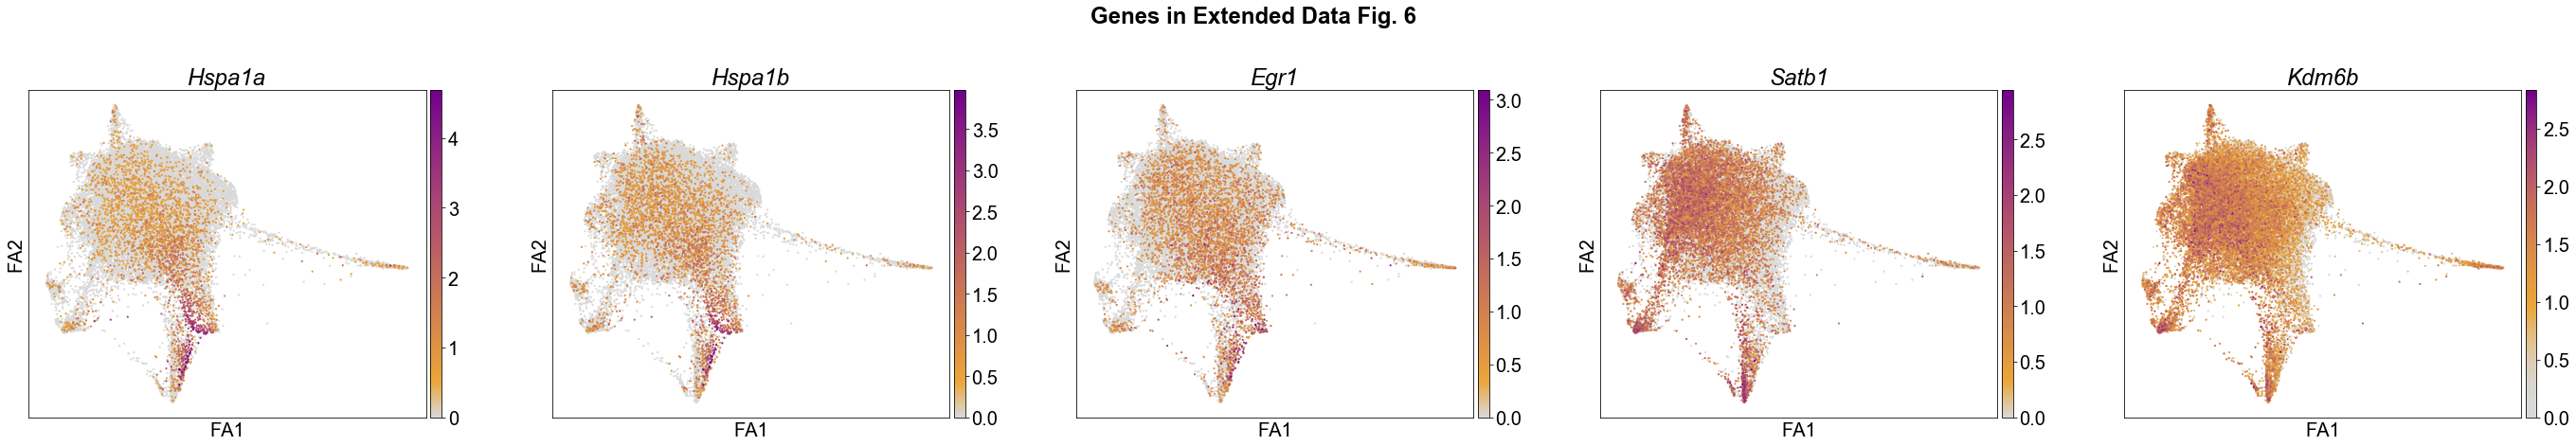

In [23]:
adata_plot = adata_full
figsize = (6.4, 4.8)

fig, axes = subplots_fixed_width(1, 5, figsize = figsize, top = 0.8)
for gene, ax in zip(edfig6_genes, axes.flatten()):
    power = cm_adjustments.get(gene, 1.0)
    plot_pointsize = 20 if restricted else 10
    sc.pl.draw_graph(adata_plot, color = gene,
                     cmap = power_cmap(cm_purple_scatter, power), s = plot_pointsize, ax = ax, show = False)
    ax.title.set_fontstyle('italic')
    title_str = f'Genes in Extended Data Fig. 6'
    fig.suptitle(title_str, weight = 'bold')

## Diffusion components, Extended Data Fig 9

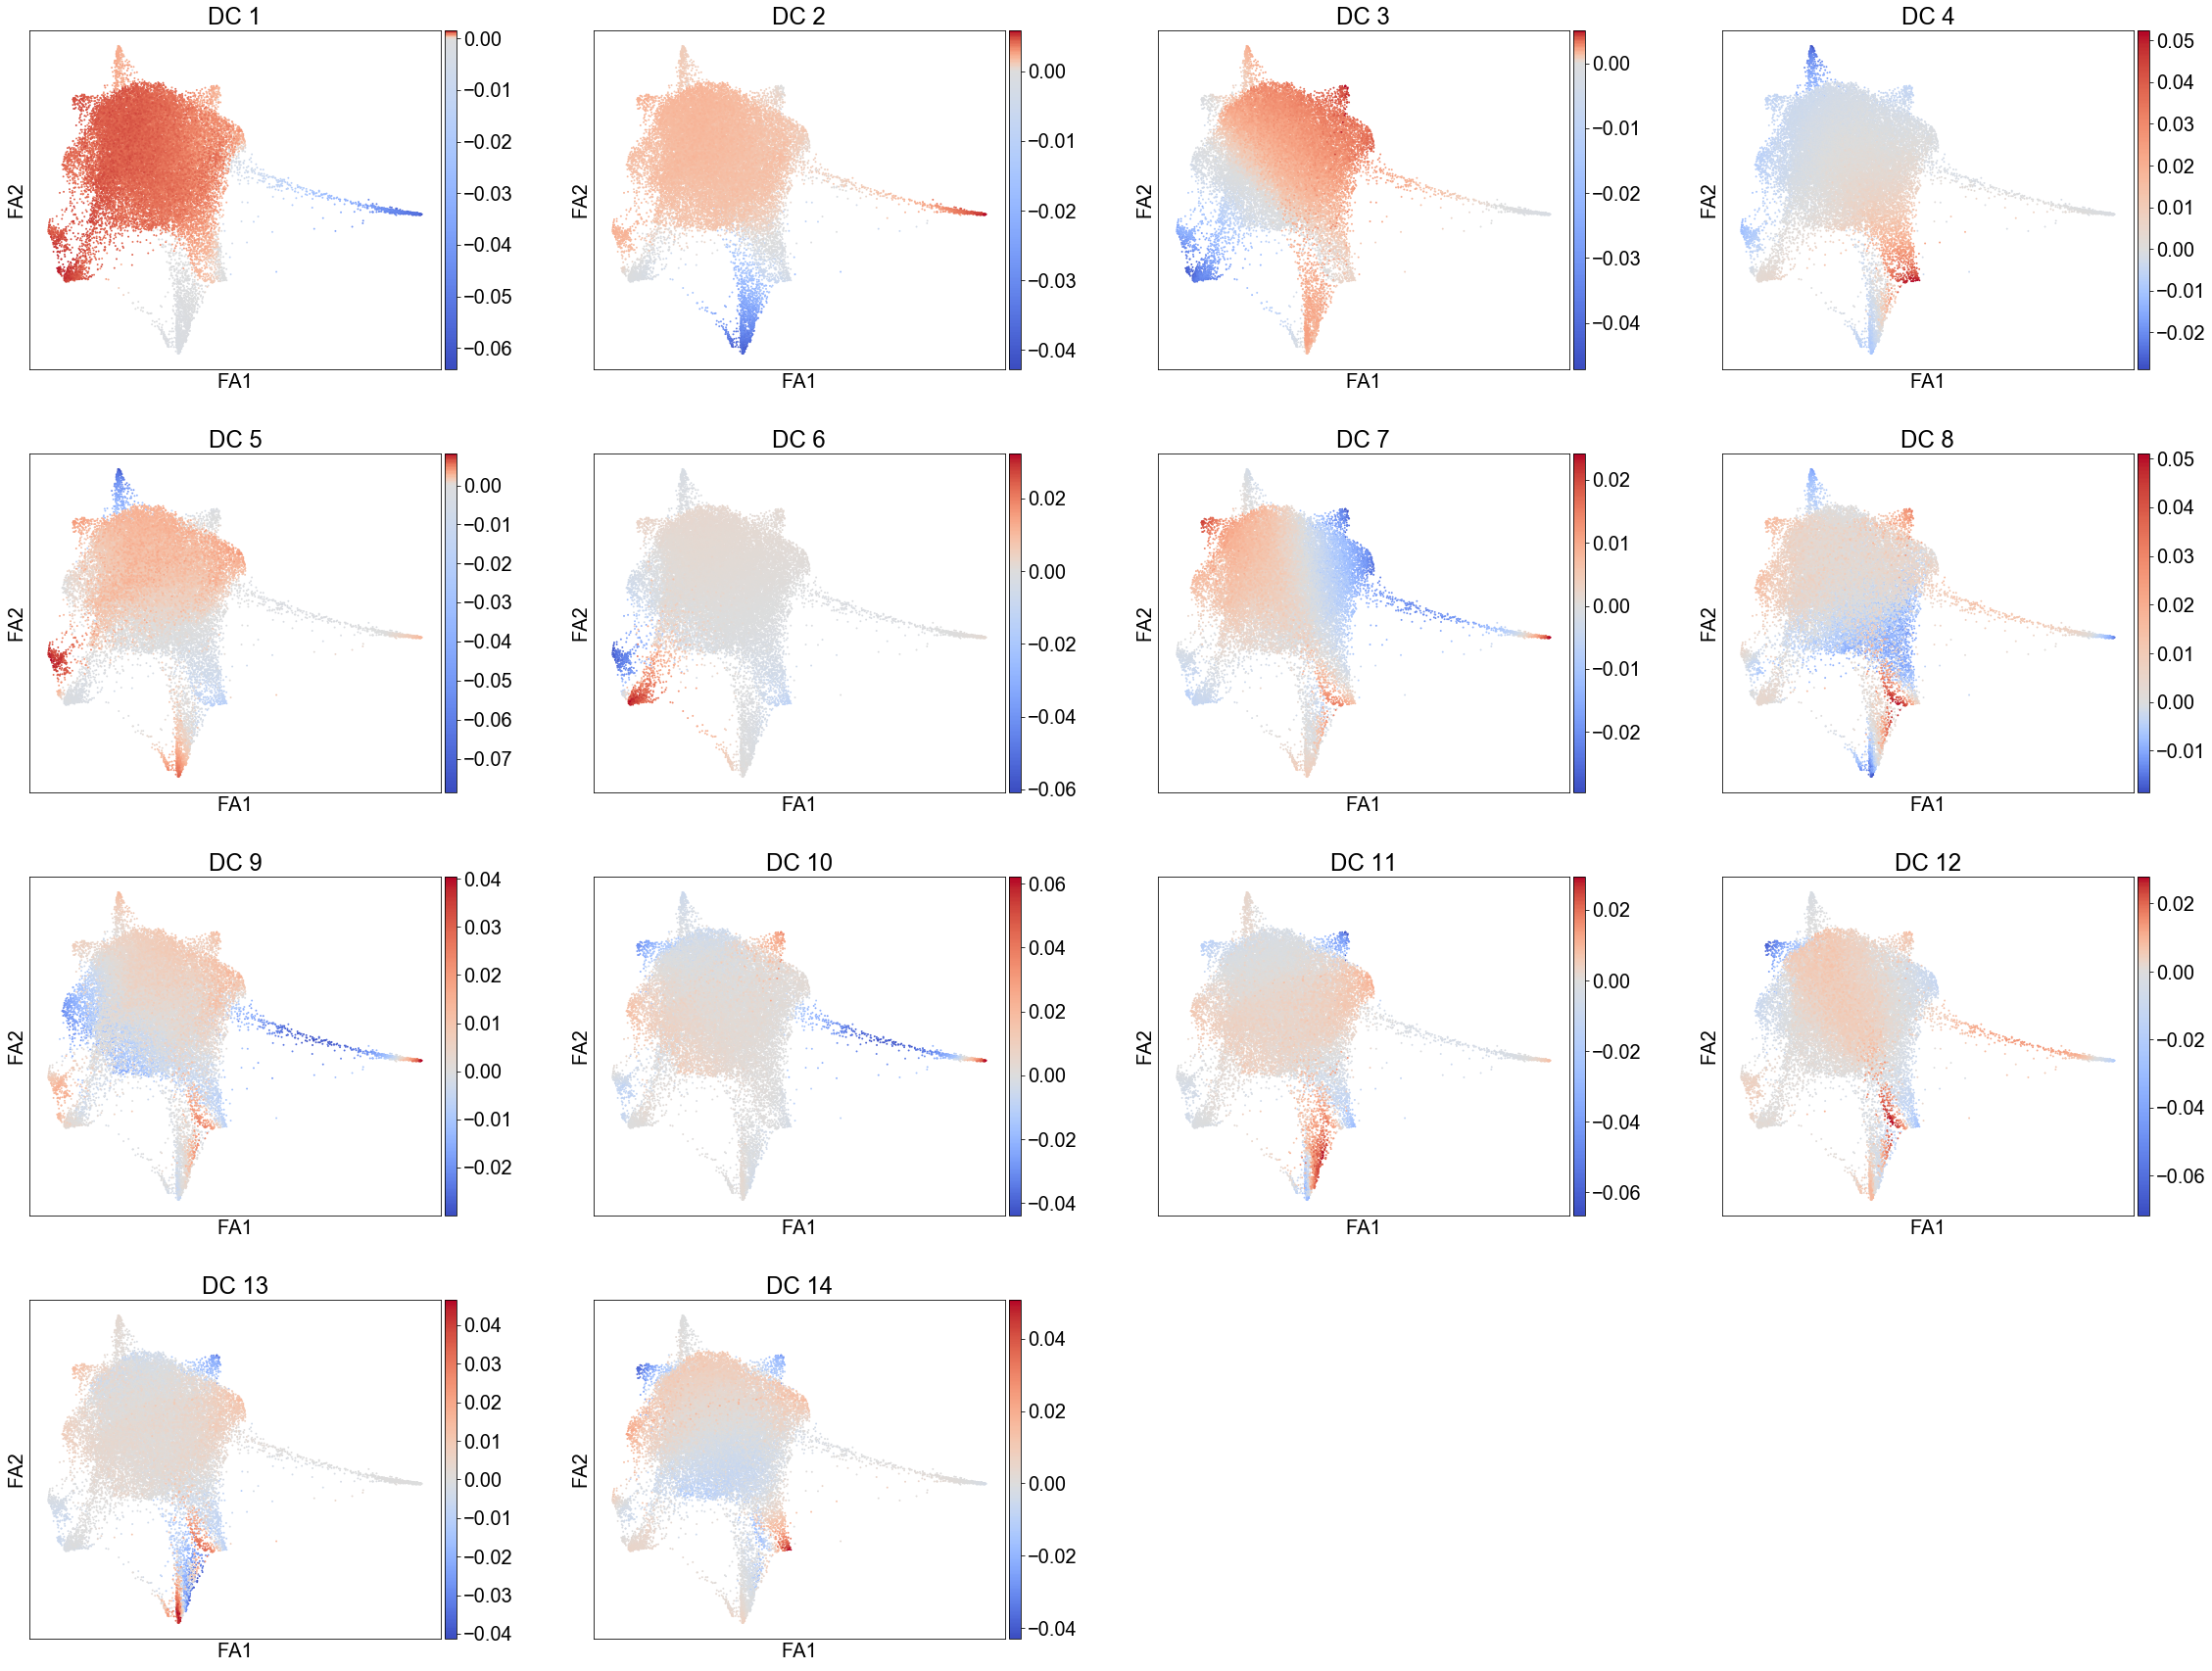

In [24]:
dc_l = ['dc_{}'.format(dc) for dc in np.arange(1, 15)]
for dc in np.arange(1,15):
    adata.obs['dc_{}'.format(dc)] = adata.obsm['X_diffmap'][:, dc]
    
fig, axes = subplots_fixed_width(4, 4, figsize = (6.4, 4.8), wspace = 0.25, hspace = 0.25)
for (i, (dc, ax)) in enumerate(zip(dc_l, axes.ravel())):
    sc.pl.draw_graph(adata, color = dc, cmap = 'coolwarm', norm = CenterNormalize(method = np.mean), ax = ax, show = False,
                    title = f'DC {i+1}', s = 15)
for i in [14, 15]:
    ax = axes.flatten()[i]
    ax.axis('off')

## Topics on diffusion components, Extended Data Fig 9

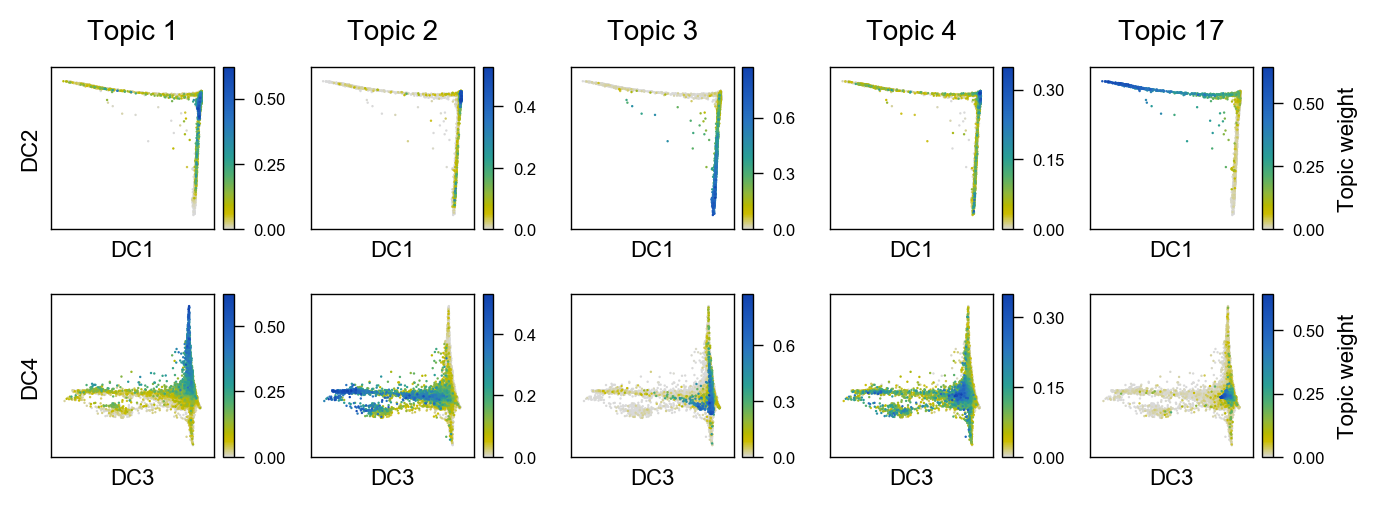

In [25]:
plot_topics = ['lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_17']
linewidth = 0.5
label_fontsize = 8
cbar_offset = 0.005

fig, axes = plt.subplots(2, 5, figsize = (7, 2.5), dpi = 200)
for (i, (t, axes_col)) in enumerate(zip(plot_topics, axes.T)):
    for (j, (components, ax)) in enumerate(zip(['1,2', '3,4'], axes_col.flatten())):
        sc.pl.diffmap(adata, color = t, components = components,
                            color_map = cm_topic, size = 3, title = [None, None],
                            show = False, ax = ax, vmin = 0)
        plt.setp([ax.yaxis.label, ax.xaxis.label], fontsize = label_fontsize)
        
        plt.setp(ax.spines.values(), linewidth = linewidth)
        if i > 0:
            ax.set_ylabel("")
        if j == 0:
            ax.set_title(f"Topic {t[4:]}", fontsize = label_fontsize + 2, pad = 10)

fig.subplots_adjust(left = 0.05, right = 0.92, top = 0.88, bottom = 0.1, wspace = 0.45, hspace = 0.4)
for i in range(10, 20):
    ax = fig.axes[i]
    ax.set_aspect(15)
    plt.setp([ax.get_children()[1]], linewidth = linewidth)
    plt.setp([ax.yaxis.get_ticklines()], markeredgewidth = linewidth)
    plt.setp([ax.yaxis.get_ticklabels()], fontsize = label_fontsize - 2)
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(3))
    bbox = ax.get_position()
    bbox.x0 += cbar_offset
    bbox.x1 += cbar_offset
    ax.set_position(bbox)
    if i >= 18:
        ax.set_ylabel("Topic weight", fontsize = label_fontsize, labelpad = 5)

## Extended Data Fig 11 genes

In [26]:
edfig11_genes = ['S100a11', 'Lgals1', 'Vim']

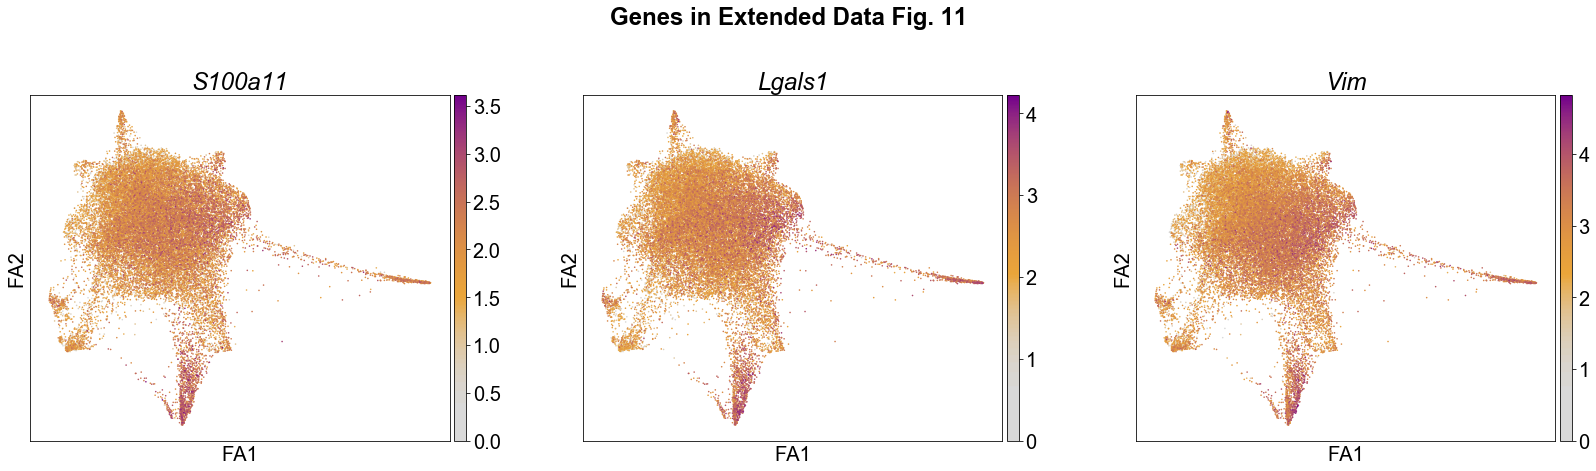

In [27]:
adata_plot = adata_full
figsize = (6.4, 4.8)

fig, axes = subplots_fixed_width(1, 3, figsize = figsize, top = 0.8)
for gene, ax in zip(edfig11_genes, axes.flatten()):
    power = cm_adjustments.get(gene, 1.0)
    sc.pl.draw_graph(adata_plot, color = gene,
                     cmap = power_cmap(cm_purple_scatter, power), s = pointsize, ax = ax, show = False)
    ax.title.set_fontstyle('italic')
    title_str = f'Genes in Extended Data Fig. 11'
    fig.suptitle(title_str, weight = 'bold')